In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def load_and_plot_csv(filename):
    df = pd.read_csv(filename)
    print(df.head())

    def filter_outliers(df, column_name):
        u_values = df[column_name].apply(lambda x: eval(x)[0])
        v_values = df[column_name].apply(lambda x: eval(x)[1])

        u_mean = u_values.mean()
        v_mean = v_values.mean()

        u_filtered = u_values[(u_values >= u_mean * 0.5) & (u_values <= u_mean * 1.5)]
        v_filtered = v_values[(v_values >= v_mean * 0.5) & (v_values <= v_mean * 1.5)]

        valid_rows = df[u_values.isin(u_filtered) & v_values.isin(v_filtered)]
        return valid_rows

    df_filtered_hook = filter_outliers(df, 'UV Hook')
    df_filtered_tip = filter_outliers(df, 'UV Tip')
    df_filtered_lowpoint = filter_outliers(df, 'UV Lowpoint')

    fig, axes = plt.subplots(3, 2, figsize=(12, 8))

    axes[0, 0].plot(df_filtered_hook['Time (s)'], df_filtered_hook['UV Hook'].apply(lambda x: eval(x)[0]), label='u Hook', color='b')
    axes[0, 1].plot(df_filtered_hook['Time (s)'], df_filtered_hook['UV Hook'].apply(lambda x: eval(x)[1]), label='v Hook', color='b')
    axes[0, 0].set_ylabel('u (Hook)')
    axes[0, 1].set_ylabel('v (Hook)')
    axes[0, 0].set_title('Hook')
    axes[0, 0].grid(True)
    axes[0, 1].grid(True)
    axes[0, 0].legend()
    axes[0, 1].legend()

    axes[0, 0].set_ylim(df_filtered_hook['UV Hook'].apply(lambda x: eval(x)[0]).min(), df_filtered_hook['UV Hook'].apply(lambda x: eval(x)[0]).max())
    axes[0, 1].set_ylim(df_filtered_hook['UV Hook'].apply(lambda x: eval(x)[1]).min(), df_filtered_hook['UV Hook'].apply(lambda x: eval(x)[1]).max())

    axes[1, 0].plot(df_filtered_tip['Time (s)'], df_filtered_tip['UV Tip'].apply(lambda x: eval(x)[0]), label='u Tip', color='g')
    axes[1, 1].plot(df_filtered_tip['Time (s)'], df_filtered_tip['UV Tip'].apply(lambda x: eval(x)[1]), label='v Tip', color='g')
    axes[1, 0].set_ylabel('u (Tip)')
    axes[1, 1].set_ylabel('v (Tip)')
    axes[1, 0].set_title('Tip')
    axes[1, 0].grid(True)
    axes[1, 1].grid(True)
    axes[1, 0].legend()
    axes[1, 1].legend()

    axes[1, 0].set_ylim(df_filtered_tip['UV Tip'].apply(lambda x: eval(x)[0]).min(), df_filtered_tip['UV Tip'].apply(lambda x: eval(x)[0]).max())
    axes[1, 1].set_ylim(df_filtered_tip['UV Tip'].apply(lambda x: eval(x)[1]).min(), df_filtered_tip['UV Tip'].apply(lambda x: eval(x)[1]).max())

    axes[2, 0].plot(df_filtered_lowpoint['Time (s)'], df_filtered_lowpoint['UV Lowpoint'].apply(lambda x: eval(x)[0]), label='u Lowpoint', color='r')
    axes[2, 1].plot(df_filtered_lowpoint['Time (s)'], df_filtered_lowpoint['UV Lowpoint'].apply(lambda x: eval(x)[1]), label='v Lowpoint', color='r')
    axes[2, 0].set_ylabel('u (Lowpoint)')
    axes[2, 1].set_ylabel('v (Lowpoint)')
    axes[2, 0].set_title('Lowpoint')
    axes[2, 0].grid(True)
    axes[2, 1].grid(True)
    axes[2, 0].legend()
    axes[2, 1].legend()

    axes[2, 0].set_ylim(df_filtered_lowpoint['UV Lowpoint'].apply(lambda x: eval(x)[0]).min(), df_filtered_lowpoint['UV Lowpoint'].apply(lambda x: eval(x)[0]).max())
    axes[2, 1].set_ylim(df_filtered_lowpoint['UV Lowpoint'].apply(lambda x: eval(x)[1]).min(), df_filtered_lowpoint['UV Lowpoint'].apply(lambda x: eval(x)[1]).max())

    for ax in axes.flat:
        ax.set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

       Time (s)                                 UV Hook  \
0  1.738935e+09  [208.8716583251953, 208.1772918701172]   
1  1.738935e+09  [208.8716583251953, 208.1772918701172]   
2  1.738935e+09  [208.8716583251953, 208.1772918701172]   
3  1.738935e+09  [208.8716583251953, 208.1772918701172]   
4  1.738935e+09  [208.8716583251953, 208.1772918701172]   

                                    UV Tip  \
0  [373.6746520996094, 299.42584228515625]   
1  [373.6746520996094, 299.42584228515625]   
2  [373.6746520996094, 299.42584228515625]   
3  [373.6746520996094, 299.42584228515625]   
4  [373.6746520996094, 299.42584228515625]   

                                UV Lowpoint  
0  [273.09991455078125, 361.78375244140625]  
1  [273.09991455078125, 361.78375244140625]  
2  [273.09991455078125, 361.78375244140625]  
3  [273.09991455078125, 361.78375244140625]  
4  [273.09991455078125, 361.78375244140625]  


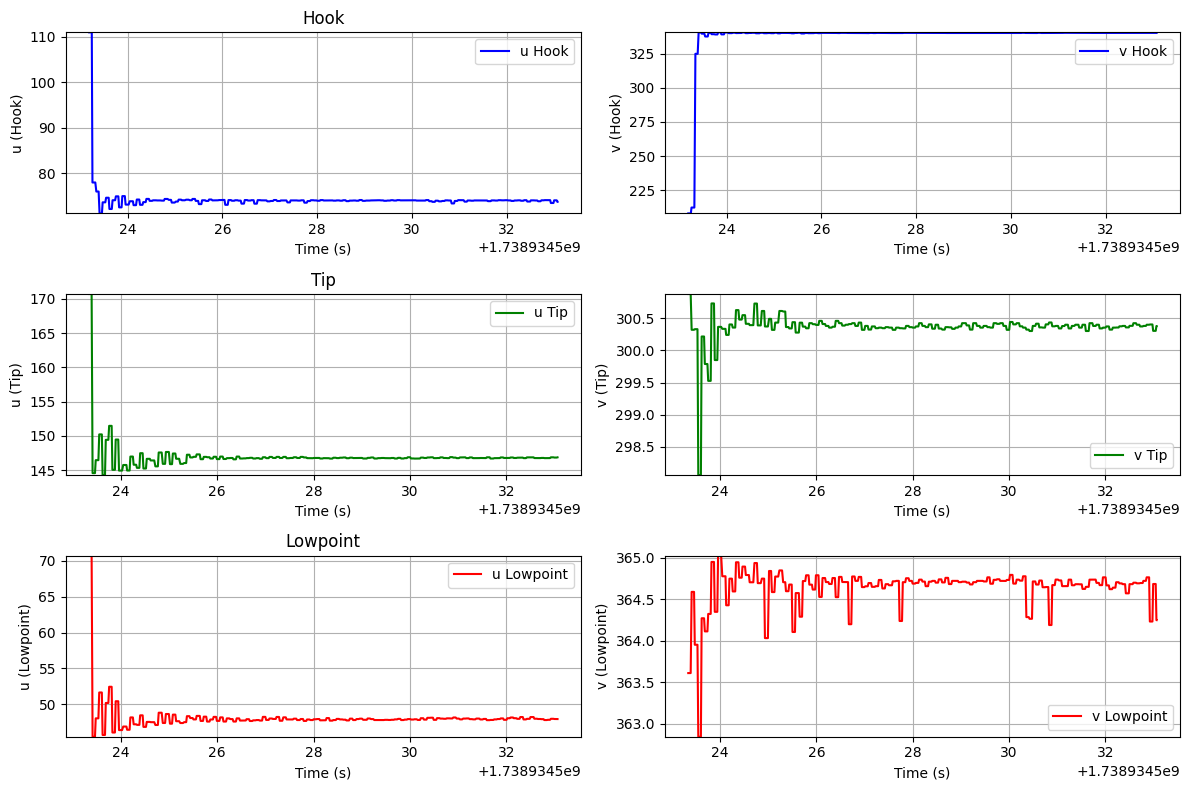

In [87]:
filename = '/home/mo/Thesis/src/robot_control/robot_control/vibration_measurement/vibration_measurement_2.csv'  # Ändere den Dateinamen nach Bedarf
load_and_plot_csv(filename)